In [116]:
from sys import maxsize

import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import QuantumCircuit
#from qiskit import Aer

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit.providers.aer import QasmSimulator
import qiskit_aer.noise as noise
from qiskit.circuit.library import UnitaryGate

#My imports
from coolingUnitary import CoolingUnitary
from mirrorProtocol import MirrorProtocol
from pairingPartnerAlgorithm import PairingPartnerAlgorithm
from minimalWorkProtocol import MinimalWorkProtocol
from utils import *

In [117]:
backendName = "ibm_osaka"

In [118]:
service = QiskitRuntimeService()
sim_backend = service.backend(backendName)
qasm_sim = AerSimulator()

In [119]:
from qiskit import QuantumCircuit
qasm = """
OPENQASM 2.0;
include "qelib1.inc";
gate nG0 a, b, c {
  x c;
  x b;
  ccx c, b, a;
  x c;
  x a;
  ccx c, a, b;
  ccx a, b, c;
  ccx c, a, b;
  x a;
  x c;
  ccx c, b, a;
  x b;
  x c;
}

qreg q[3];
creg c[3];

barrier q[0];
barrier q[1];
barrier q[2];
x q[1];
x q[2];
ccx q[2], q[1], q[0];
x q[1];
x q[2];
barrier;
x q[0];
x q[2];
ccx q[0], q[2], q[1];
x q[0];
x q[2];
barrier;
x q[0];
ccx q[0], q[1], q[2];
x q[0];
barrier;
x q[0];
x q[2];
ccx q[0], q[2], q[1];
x q[0];
x q[2];
barrier;
x q[1];
x q[2];
ccx q[2], q[1], q[0];
x q[1];
x q[2];

// @columns [0,0,0,1,1,2,3,3,4,4,4,5,5,6,7,7,8,8,8,9,10,11,12,12,12,13,13,14,15,15,16,16,16,17,17,18,19,19]

"""
circuit = QuantumCircuit.from_qasm_str(qasm)

In [142]:
qasm = """
OPENQASM 2.0;
include "qelib1.inc";
gate nG0 a, b, c {
  x c;
  x b;
  ccx c, b, a;
  x c;
  x a;
  ccx c, a, b;
  ccx a, b, c;
  ccx c, a, b;
  x a;
  x c;
  ccx c, b, a;
  x b;
  x c;
}

qreg q[3];
creg c[3];

x q[1];
x q[2];
ccx q[2], q[1], q[0];
x q[1];
x q[2];
x q[0];
x q[2];
ccx q[0], q[2], q[1];
x q[0];
x q[2];
x q[0];
ccx q[0], q[1], q[2];
x q[0];
x q[0];
x q[2];
ccx q[0], q[2], q[1];
x q[0];
x q[2];
x q[1];
x q[2];
ccx q[2], q[1], q[0];
x q[1];
x q[2];

// @columns [0,0,0,1,1,2,3,3,4,4,4,5,5,6,7,7,8,8,8,9,10,11,12,12,12,13,13,14,15,15,16,16,16,17,17,18,19,19]

"""
circuit = QuantumCircuit.from_qasm_str(qasm)

In [151]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.barrier()
circuit.x(qreg_q[0])
circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.x(qreg_q[0])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[0], qreg_q[2], qreg_q[1])
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[2], qreg_q[1], qreg_q[0])
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[0], qreg_q[2], qreg_q[1])
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.x(qreg_q[0])
# @columns [1,1,1,2,3,4,5,5,5,6,6,7,8,8,9,9,9,10,10,11,12,12,13,13,13,14,14,15,16,16,17,17,17,18,19,20]

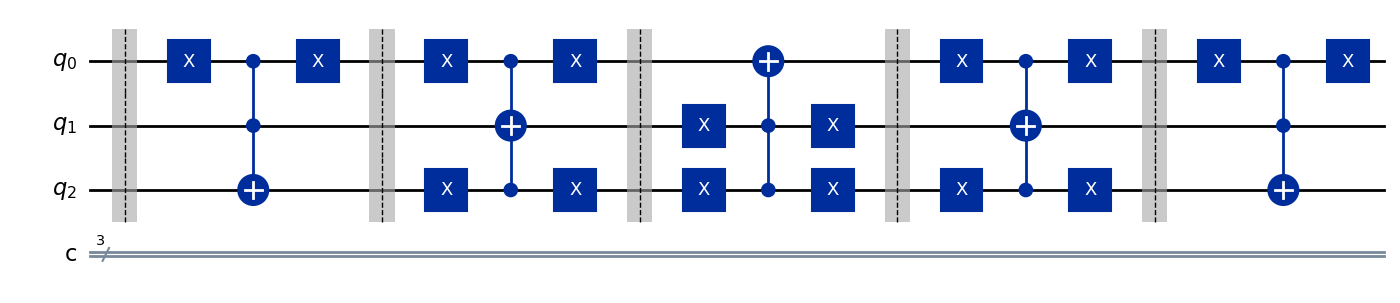

In [152]:
circuit.draw('mpl')

In [157]:
n = 3
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    total_circ.compose(circuit, qubits=[q_regs[2],q_regs[1],q_regs[0]], inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    #total_circ.measure(0, c_regs)
    transpiledCircuit = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    circuits.append(transpiledCircuit)

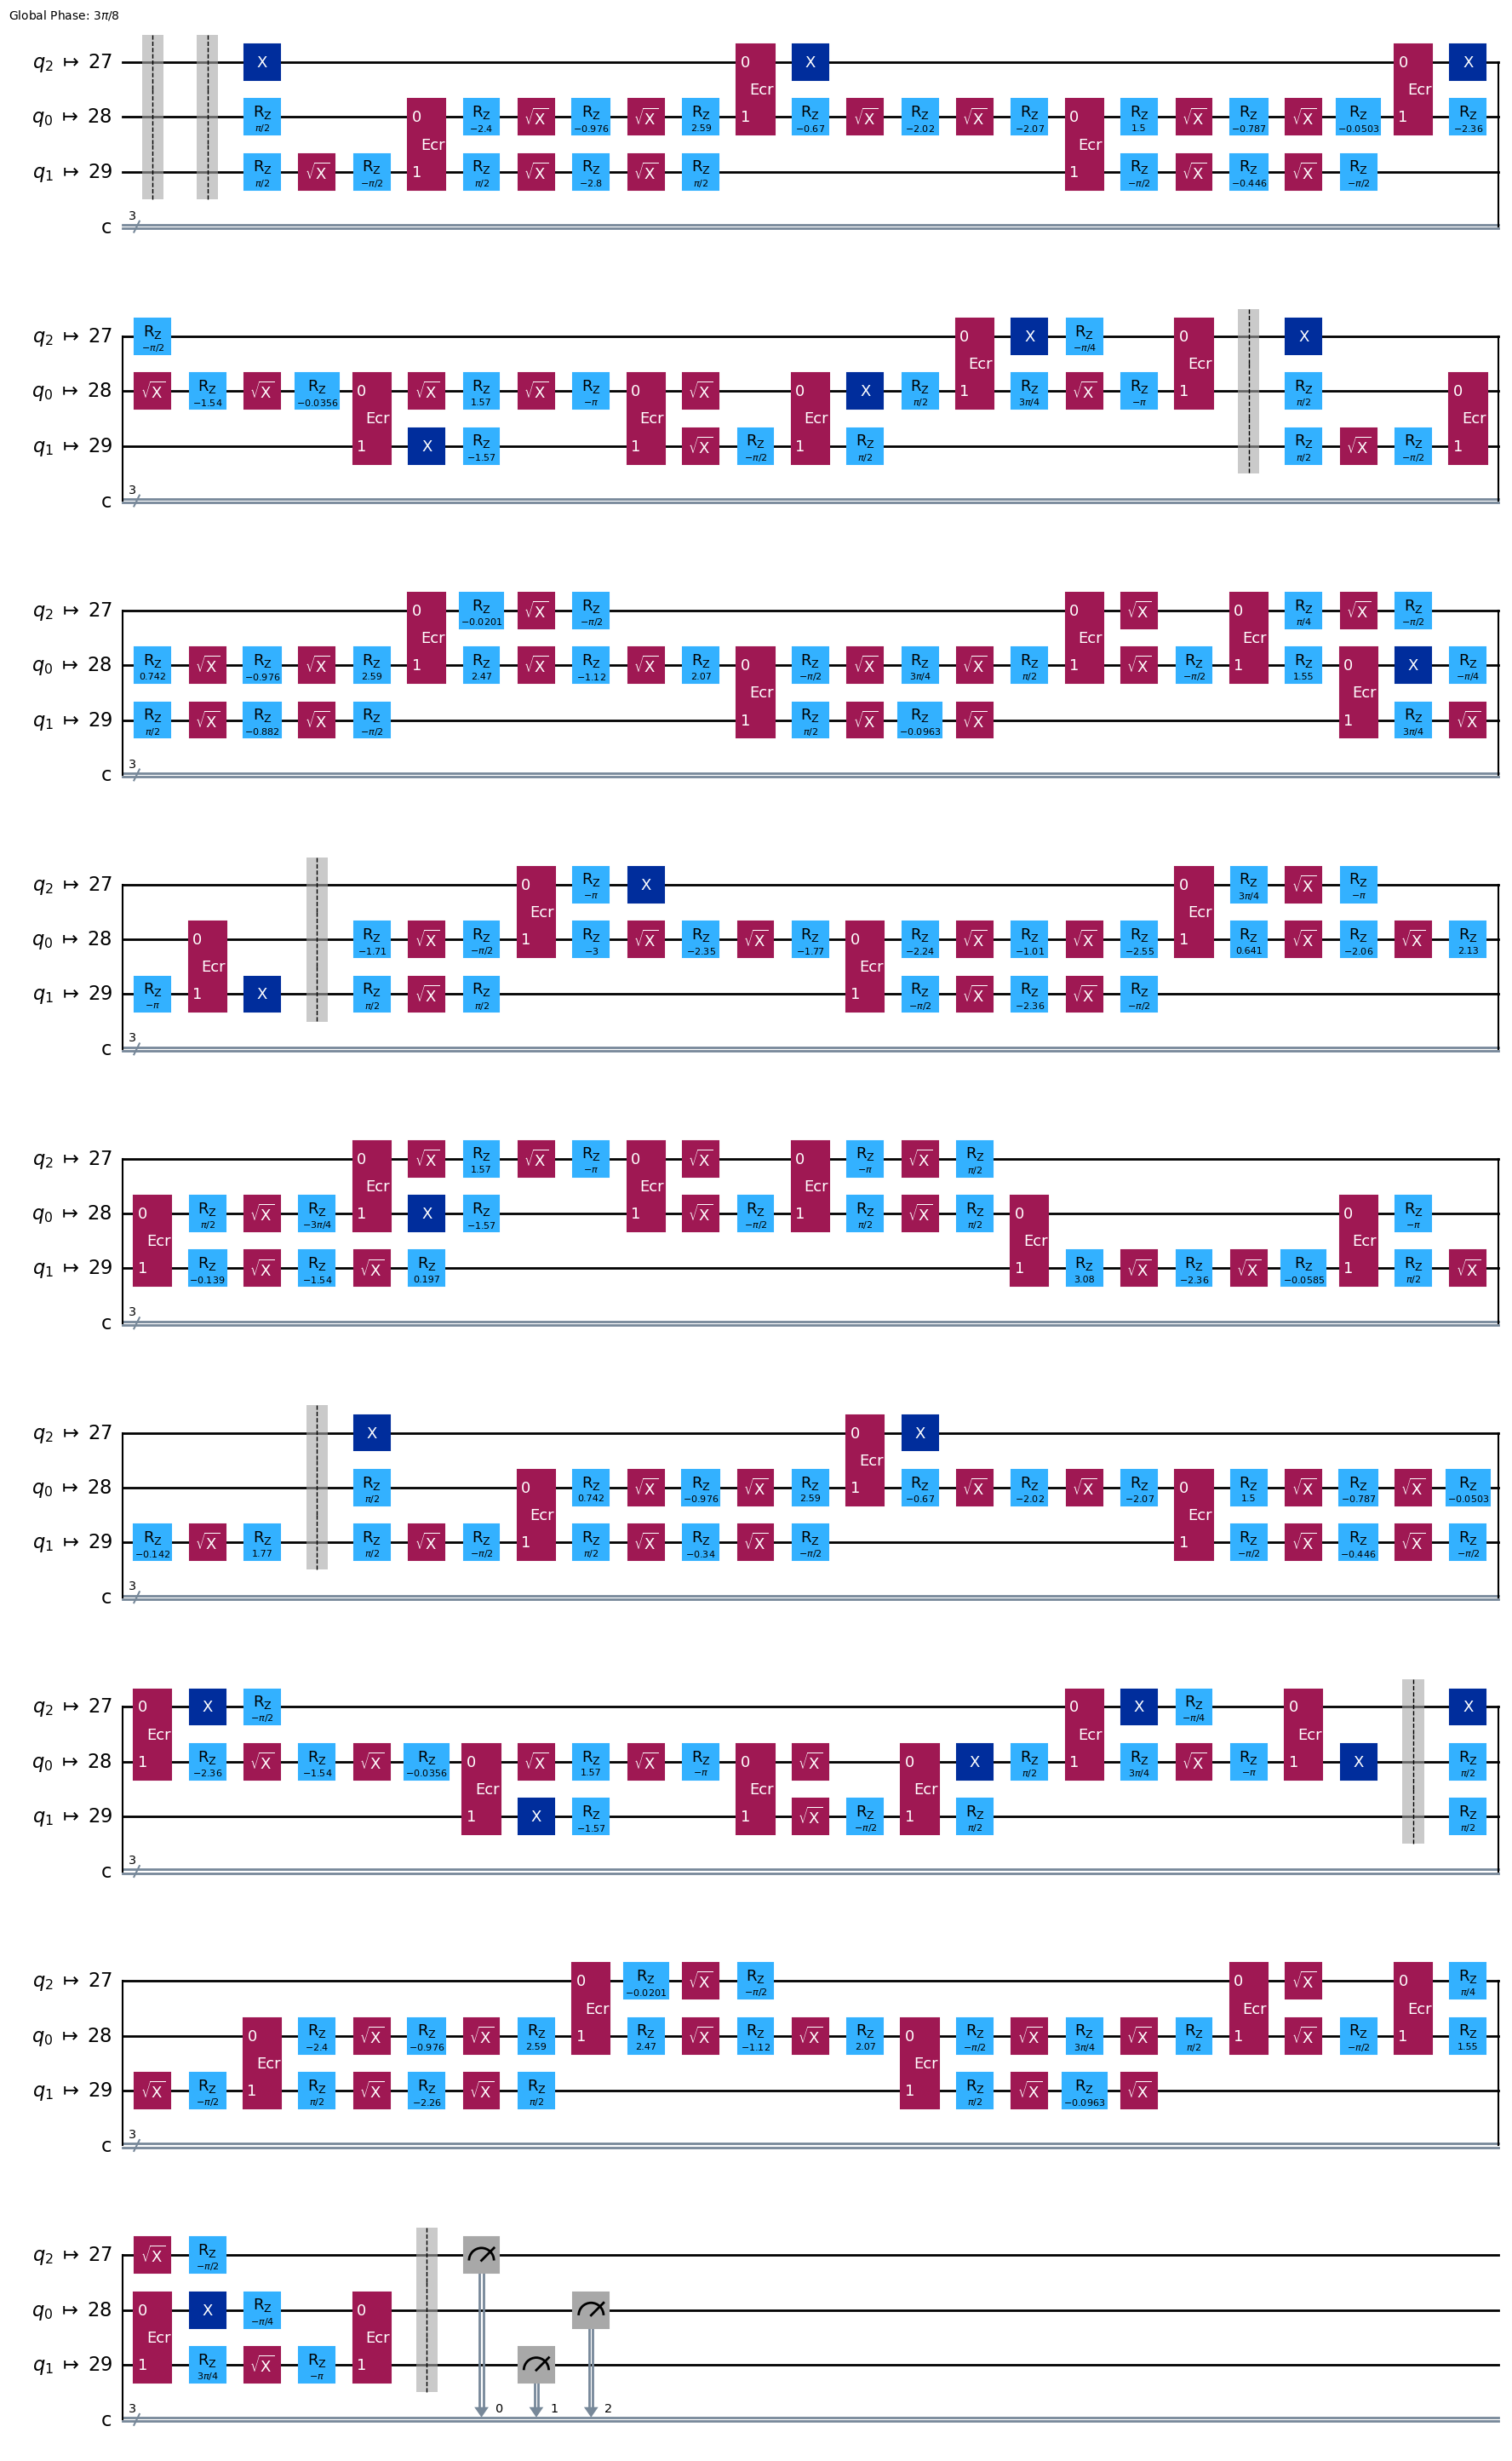

In [158]:
circuits[0].draw('mpl',idle_wires=False)

In [160]:
circuits[0].count_ops()

OrderedDict([('rz', 153),
             ('sx', 92),
             ('ecr', 41),
             ('x', 20),
             ('barrier', 7),
             ('measure', 3)])

In [156]:
counts = []
for i in range(num_circs):
    result = qasm_sim.run(circuits[i]).result()
    counts.append(result.get_counts())
    print(format(i,'b').zfill(n) + " " + str(counts[i]))

000 {'000': 1024}
001 {'001': 1024}
010 {'010': 1024}
011 {'100': 1024}
100 {'011': 1024}
101 {'101': 1024}
110 {'110': 1024}
111 {'111': 1024}


In [171]:
n = 5
a = MinimalWorkProtocol(n,0.01)
checkUnitary(a)
cooling_circuit = QuantumCircuit(n)
cooling_circuit.append(UnitaryGate(a),range(n))


0 | 00000 --> 00000
1 | 00001 --> 00001
2 | 00010 --> 00010
3 | 00011 --> 10000 (*)
4 | 00100 --> 00100
5 | 00101 --> 00101
6 | 00110 --> 00110
7 | 00111 --> 11000 (*)
8 | 01000 --> 01000
9 | 01001 --> 01001
10 | 01010 --> 01010
11 | 01011 --> 10100 (*)
12 | 01100 --> 01100
13 | 01101 --> 10010 (*)
14 | 01110 --> 10001 (*)
15 | 01111 --> 00011 (*)
-------------------------
16 | 10000 --> 11100 (*)
17 | 10001 --> 01110 (*)
18 | 10010 --> 01101 (*)
19 | 10011 --> 10011
20 | 10100 --> 01011 (*)
21 | 10101 --> 10101
22 | 10110 --> 10110
23 | 10111 --> 10111
24 | 11000 --> 00111 (*)
25 | 11001 --> 11001
26 | 11010 --> 11010
27 | 11011 --> 11011
28 | 11100 --> 01111 (*)
29 | 11101 --> 11101
30 | 11110 --> 11110
31 | 11111 --> 11111


In [172]:
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2]], inplace=True)
    total_circ.compose(cooling_circuit, inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    transpiledCircuitUnitary = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    #total_circ.measure(0, c_regs)
    circuits.append(transpiledCircuitUnitary)

In [173]:
circuits[0].draw('mpl',idle_wires=False)

ValueError: Image size of 2281x104129 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2281.67x104129 with 1 Axes>

In [176]:
circuits[0].count_ops()

OrderedDict([('rz', 3342),
             ('sx', 2505),
             ('ecr', 966),
             ('x', 175),
             ('measure', 5),
             ('barrier', 2)])

# QUA QUA QUA

In [207]:
counts = []

for i in range(num_circs):
    result = qasm_sim.run(circuits[i],shots = 1).result()
    counts.append(result.get_counts())
    #print(i, list(counts[i])[0])
    if(format(i,'b').zfill(n) == list(counts[i])[0]):
        print(format(i).zfill(num_circs % 10) + " | " + format(i,'b').zfill(n) + " --> " + str(list(counts[i])[0]))
    else:
        print(format(i).zfill(num_circs % 10) + " | " + format(i,'b').zfill(n) + " --> " + str(list(counts[i])[0]) + " (*)")


00 | 00000 --> 00000
01 | 00001 --> 00001
02 | 00010 --> 00010
03 | 00011 --> 10000 (*)
04 | 00100 --> 00100
05 | 00101 --> 00101
06 | 00110 --> 00110
07 | 00111 --> 11000 (*)
08 | 01000 --> 01000
09 | 01001 --> 01001
10 | 01010 --> 01010
11 | 01011 --> 10100 (*)
12 | 01100 --> 01100
13 | 01101 --> 10010 (*)
14 | 01110 --> 10001 (*)
15 | 01111 --> 00011 (*)
16 | 10000 --> 11100 (*)
17 | 10001 --> 01110 (*)
18 | 10010 --> 01101 (*)
19 | 10011 --> 10011
20 | 10100 --> 01011 (*)
21 | 10101 --> 10101
22 | 10110 --> 10110
23 | 10111 --> 10111
24 | 11000 --> 00111 (*)
25 | 11001 --> 11001
26 | 11010 --> 11010
27 | 11011 --> 11011
28 | 11100 --> 01111 (*)
29 | 11101 --> 11101
30 | 11110 --> 11110
31 | 11111 --> 11111


In [178]:
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2]], inplace=True)
    total_circ.compose(cooling_circuit, inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    #transpiledCircuitUnitary = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    #total_circ.measure(0, c_regs)
    circuits.append(total_circ)

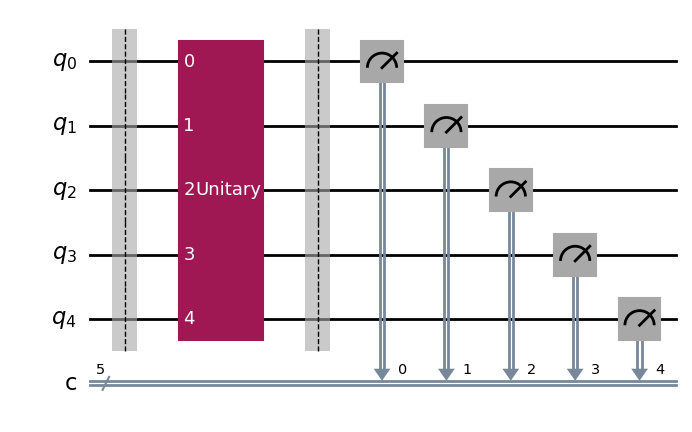

In [179]:
circuits[0].draw('mpl',idle_wires=False)

In [180]:
transpiledCircuitUnitary = qk.transpile(circuits, backend=sim_backend,optimization_level=3)

In [182]:
transpiledCircuitUnitary[0].draw(idle_wires=False)

global phase: 5π/4
           ░  ┌────────────┐   ┌────┐  ┌─────────────┐┌────┐ ┌────────────┐ »
q_1 -> 91 ─░──┤ Rz(3.1266) ├───┤ √X ├──┤ Rz(-1.6988) ├┤ √X ├─┤ Rz(0.6711) ├─»
           ░  └───┬────┬───┘┌──┴────┴─┐└─────────────┘└────┘ └────────────┘ »
q_4 -> 96 ─░──────┤ √X ├────┤ Rz(π/2) ├─────────────────────────────────────»
           ░  ┌───┴────┴───┐└──┬────┬─┘                                     »
q_3 -> 97 ─░──┤ Rz(1.2732) ├───┤ √X ├───────────────────────────────────────»
           ░  ├────────────┤   ├────┤  ┌─────────────┐┌────┐┌──────────────┐»
q_0 -> 98 ─░──┤ Rz(2.8599) ├───┤ √X ├──┤ Rz(-1.4576) ├┤ √X ├┤ Rz(-0.67732) ├»
           ░ ┌┴────────────┤   ├────┤  └──┬────────┬─┘└────┘└──────────────┘»
q_2 -> 99 ─░─┤ Rz(0.43434) ├───┤ √X ├─────┤ Rz(-π) ├────────────────────────»
           ░ └─────────────┘   └────┘     └────────┘                        »
     c: 5/══════════════════════════════════════════════════════════════════»
                                                                            »
«          ┌──────┐┌─────────────┐     ┌────┐    ┌────────┐            ┌──────┐»
«q_1 -> 91 ┤1     ├┤ Rz(-1.9617) ├─────┤ √X ├────┤ Rz(-π) ├────────────┤1     ├»
«          │      │└─────────────┘     └────┘    └────────┘            │      │»
«q_4 -> 96 ┤      ├────────────────────────────────────────────────────┤      ├»
«          │  Ecr │                                                    │  Ecr │»
«q_3 -> 97 ┤      ├────────────────────────────────────────────────────┤      ├»
«          │      │     ┌────┐    ┌─────────────┐  ┌────┐  ┌──────────┐│      │»
«q_0 -> 98 ┤0     ├─────┤ √X ├────┤ Rz(-1.9234) ├──┤ √X ├──┤ Rz(-π/2) ├┤0     ├»
«          └──────┘     └────┘    └─────────────┘  └────┘  └──────────┘└──────┘»
«q_2 -> 99 ────────────────────────────────────────────────────────────────────»
«                                                                              »
«     c: 5/════════════════════════════════════════════════════════════════════»
«                                                                              »
«          ┌──────────────┐┌────┐┌─────────────┐┌────┐┌──────────────┐        »
«q_1 -> 91 ┤ Rz(-0.13328) ├┤ √X ├┤ Rz(-1.5798) ├┤ √X ├┤ Rz(-0.78702) ├────────»
«          └──────────────┘└────┘└─────────────┘└────┘└──────────────┘        »
«q_4 -> 96 ───────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3 -> 97 ───────────────────────────────────────────────────────────────────»
«          ┌─────────────┐ ┌────┐┌─────────────┐┌────┐┌─────────────┐ ┌──────┐»
«q_0 -> 98 ┤ Rz(-2.8746) ├─┤ √X ├┤ Rz(-2.5303) ├┤ √X ├┤ Rz(0.70342) ├─┤1     ├»
«          └─────────────┘ └────┘└─────────────┘└────┘└─────────────┘ │  Ecr │»
«q_2 -> 99 ───────────────────────────────────────────────────────────┤0     ├»
«                                                                     └──────┘»
«     c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                         »
«q_1 -> 91 ───────────────────────────────────────────────────────────────»
«                                                                         »
«q_4 -> 96 ───────────────────────────────────────────────────────────────»
«                                                                         »
«q_3 -> 97 ───────────────────────────────────────────────────────────────»
«          ┌────┐┌──────────┐┌──────┐   ┌────┐   ┌─────────────┐  ┌────┐  »
«q_0 -> 98 ┤ √X ├┤ Rz(-π/2) ├┤1     ├───┤ √X ├───┤ Rz(-1.6135) ├──┤ √X ├──»
«          ├────┤└──────────┘│  Ecr │┌──┴────┴──┐└────┬────┬───┘┌─┴────┴─┐»
«q_2 -> 99 ┤ √X ├────────────┤0     ├┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(-π) ├»
«          └────┘            └──────┘└──────────┘     └────┘    └────────┘»
«     c: 5/═══════════════════════════